# This script aims to select parameters for DF-counting using low dose frames
<br> Two parameters need to be selected to construct semi-counting image: intensit threshold and area threshold
<br> Based on frame acquired with no electron, mean non-zero background is 1.5 with std around 1, so it is save to select 15 as intensity threshold.
<br> 

In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
from skimage import measure
from skimage import filters

### Histogram of blank frames

In [7]:
from skimage import measure
from skimage import filters
# path to npy files that contains images
path = '/srv/home/chenyu/DEbackup/2019/050619/Blank/npy/'
frame_list = []

for iframe in range(1,len(glob.glob(path+'/*.npy'))):
    frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
    frame_list.append(frame)

Text(0.5, 1.0, 'Intensity histogram without beam')

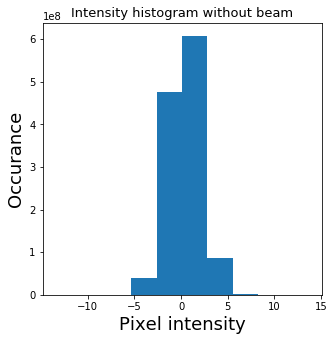

In [8]:
# Plot histogram of intensity
fig = plt.figure(figsize=(5,5))
fig.add_subplot(1,1,1)
plt.hist(np.ndarray.flatten(np.asarray(frame_list)))
# plt.title('SEevent intensity')
plt.xlabel('Pixel intensity',fontsize=18)
plt.ylabel('Occurance',fontsize=18)
plt.title('Intensity histogram without beam',fontsize=13)

In [9]:
np.mean(np.asarray(frame_list))

0.4111835984238554

### Number of events collected on blank frames under different threshold, i.e. false positive

In [53]:
path = '/srv/home/chenyu/DEbackup/050619/Blank/npy/'
nevents = np.zeros(20)

for threshold in range(5,21):
    for iframe in range(1,100):
        frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
        frame_binary = np.heaviside(frame-threshold,1)
        all_labels = measure.label(frame_binary)
        blob_labels = measure.label(frame_binary, background=0)
        ncomponents = np.amax(all_labels)
        nevents[threshold-5] = nevents[threshold-5] + ncomponents

In [57]:
nevents[10]

0.0

Text(0.5, 1.0, 'Events collected without beam')

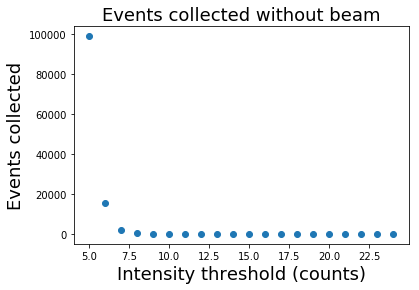

In [55]:
plt.scatter(np.linspace(5,24,20),nevents)
plt.xlabel('Intensity threshold (counts)',fontsize=18)
plt.ylabel('Events collected',fontsize=18)
plt.title('Events collected without beam',fontsize=18)

### Number of events collected on blank frames under different threshold, i.e. false positive

In [103]:
path = '/srv/home/chenyu/DEbackup/050619/LowDoseSTEM/npy/'
nevents = np.zeros(20)

for threshold in range(5,25):
    for iframe in range(1,100):
        frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
        frame_binary = np.heaviside(frame-threshold,1)
        all_labels = measure.label(frame_binary)
        blob_labels = measure.label(frame_binary, background=0)
        ncomponents = np.amax(all_labels)
        nevents[threshold-5] = nevents[threshold-5] + ncomponents

Text(0.5, 1.0, 'Events collected under low dose')

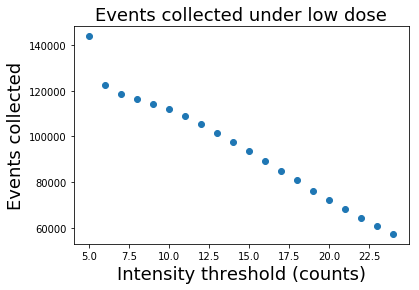

In [105]:
plt.scatter(np.linspace(5,24,20),nevents)
plt.xlabel('Intensity threshold (counts)',fontsize=18)
plt.ylabel('Events collected',fontsize=18)
plt.title('Events collected under low dose',fontsize=18)

Text(0.5, 1.0, 'Counting mode')

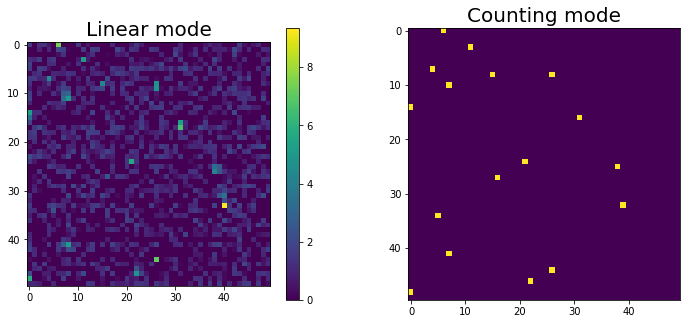

In [131]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(1,2,1)

frame_nonzero = frame
frame_nonzero[frame_nonzero<0]=0
plt.imshow(np.sqrt(frame_nonzero[150:200,100:150]))
plt.colorbar()
plt.title('Linear mode',fontsize=20)

fig.add_subplot(122)
plt.imshow(frame_counting[150:200,100:150])
plt.title('Counting mode',fontsize=20)

In [41]:
from skimage import measure
from skimage import filters
# path to npy files that contains images
path = '/srv/home/chenyu/DEbackup/2019/050619/LowDoseSTEM/npy/'
SEint_list = []
SEsize_list = []
int_dist = np.zeros((10,10))

for iframe in range(1,1000):
    frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')

    # Remove left edge as it contains noise pixels due to sensor artiface
#     frame = frame[:,50:-1]
    frame_binary = np.heaviside(frame-15,1)
    all_labels = measure.label(frame_binary)
    blob_labels = measure.label(frame_binary, background=0)
    ncomponents = np.amax(all_labels)
    frame_counting = np.zeros(frame.shape)

    # Ignore first component as it represent background
    for i in range(1,ncomponents):
        SEsize_list.append(np.where(all_labels == i)[0].shape[0])

        component_idx = np.where(all_labels == i)

        # append total intensity of this SE event to the total
        int_list = frame[component_idx[0],component_idx[1]]
        cor_row = int(np.average(component_idx[0],weights=int_list))
        cor_col = int(np.average(component_idx[1],weights=int_list))
        frame_counting[cor_row, cor_col] = 1
        if cor_row > 5 and cor_col > 5 and cor_row < 507 and cor_col < 507:
            int_dist = int_dist + frame[cor_row-5:cor_row+5,cor_col-5:cor_col+5]
        SEint_list.append(np.sum(int_list))

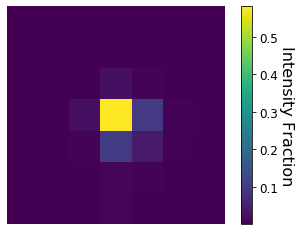

In [55]:
plt.imshow((int_dist/np.sum(int_dist))[2:-1,2:-1])
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Intensity Fraction',rotation=270,fontsize=16, labelpad = 16)

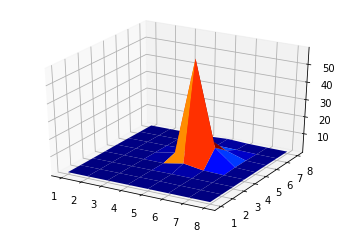

In [72]:
from mpl_toolkits import mplot3d
%matplotlib inline
from matplotlib import cm

ax = plt.axes(projection='3d')
X2, Y2 = np.meshgrid(range(10), range(10))
Z2 = int_dist/np.sum(int_dist)
ax.plot_surface(X2[1:-1,1:-1], Y2[1:-1,1:-1], Z2[1:-1,1:-1]*100,cmap='jet')

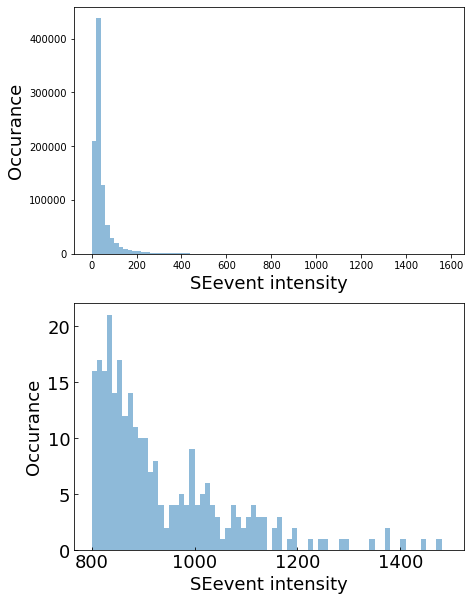

46.968756999045354


In [32]:
# Plot histogram of intensity
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(211)
bins = np.arange(0, np.amax(np.asarray(SEint_list)), 20) # fixed bin size
plt.hist(np.asarray(SEint_list), bins=bins, alpha=0.5)
# plt.title('SEevent intensity')
plt.xlabel('SEevent intensity',fontsize=18)
plt.ylabel('Occurance',fontsize=18)

ax = fig.add_subplot(212)
bins = np.arange(800, 1500, 10) # fixed bin size
plt.hist(np.asarray(SEint_list), bins = bins, alpha = 0.5)
plt.xlabel('SEevent intensity',fontsize=18)
plt.ylabel('Occurance',fontsize=18)
ax.tick_params(direction='in',labelsize = 18)
plt.show()

print(np.mean(np.asarray(SEint_list)))

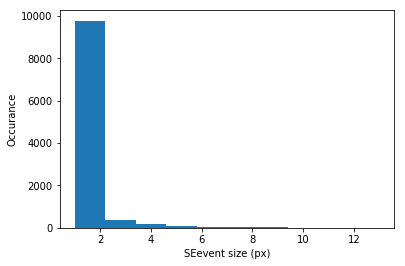

In [42]:
# Plot histogram of SE event size
plt.hist(np.asarray(SEsize_list))
plt.xlabel('SEevent size (px)')
plt.ylabel('Occurance')
plt.show()

## Calculate gain factor using blank scan and low dose scan

In [30]:
path_lowdose = '/srv/home/chenyu/DEbackup/050619/LowDoseSTEM/npy/'
path_nobeam = '/srv/home/chenyu/DEbackup/050619/Blank/npy/'
num_frames = 100
num_electrons = 0
int_lowdose = 0
int_nobeam = 0

for iframe in range(1000,3500):
    
    # load frame from low dose STEM and calculate total number of electrons
    frame = np.load(path_lowdose + 'S0_' + format(iframe,'05') + '.npy')
    int_lowdose = int_lowdose + np.sum(frame)
    frame_binary = np.heaviside(frame-10,1)
    all_labels = measure.label(frame_binary)
    ncomponents = np.amax(all_labels)
    num_electrons = num_electrons + ncomponents
    
    # load frame from no beam and calculate background intensity
    frame = np.load(path_nobeam + 'S0_' + format(iframe,'05') + '.npy')
    int_nobeam = int_nobeam + np.sum(frame)

print(int_lowdose)
print(int_nobeam)

-22289901.7429702
274346592.8071752


-24213.886051907124
-0.09236864491236543


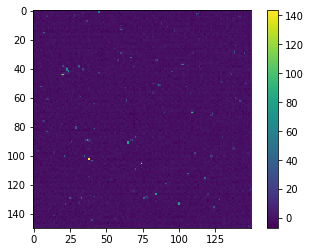

In [33]:
frame = np.load(path_lowdose + 'S0_' + format(iframe,'05') + '.npy')
print(frame.sum())
print(frame.sum()/512/512)
plt.imshow(frame[0:150,0:150])
# plt.clim([-4,4])
plt.colorbar()

52010.85695194197
0.19840567379738605


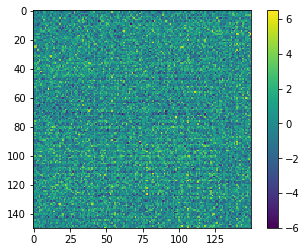

In [34]:
frame = np.load(path_nobeam + 'S0_' + format(iframe,'05') + '.npy')
print(frame.sum())
print(frame.sum()/512/512)
plt.imshow(frame[0:150,0:150])
# plt.clim([-4,4])
plt.colorbar()

## Calculate frame intensity vs electron amount
One of previous observation was frame intensity gets lower compared to no beam when there is a low current beam on the sensor.

In [117]:
from skimage import measure
from skimage import filters
nevent_list = []
intensity_list = []
path = '/srv/home/chenyu/DEbackup/053019/LowDoseSeries/npy/'
for iframe in range(1,35000):
    frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
    frame_binary = np.heaviside(frame-16,1)
    all_labels = measure.label(frame_binary)
    ncomponents = np.amax(all_labels)
    intensity_list.append(np.sum(frame))
    nevent_list.append(ncomponents)

In [122]:
z = np.polyfit(np.asarray(nevent_list)[25000:35000], np.asarray(intensity_list)[25000:35000], 1)
print(z)

[    76.74390377 -72838.78388797]


(array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 10 Text yticklabel objects>)

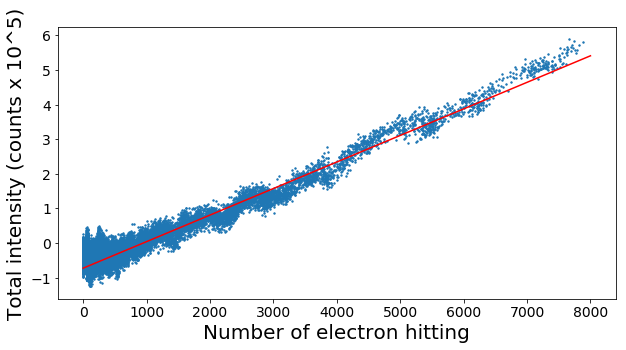

In [124]:
fig = plt.figure(figsize=(10,5))
im = plt.scatter(np.asarray(nevent_list),np.asarray(intensity_list)/100000,s=2)
x_list = np.linspace(0,8000,10000)
y_list = x_list * z[0] + z[1]
plt.plot(x_list,y_list/100000,c='red')
plt.xlabel('Number of electron hitting',fontsize=20)
plt.ylabel('Total intensity (counts x 10^5)',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Check cross-talk from one frame to the next

In [135]:
intensity_list = []
path = '/srv/home/chenyu/DEbackup/053019/LowDoseSeries/npy/'
for iframe in range(1,35000):
    frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
    intensity_list.append(frame[100,100])

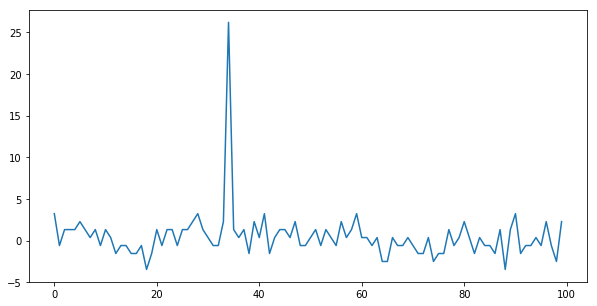

In [144]:
fig = plt.figure(figsize=(10,5))
im = plt.plot(np.asarray(intensity_list)[29350:29450])

## DE's old method of calculate gain factor
Use a window with 13px radius from each event

In [84]:
nevent_list = []
intensity_list = []
path = '/srv/home/chenyu/DEbackup/053019/LowDoseSeries/npy/'
for iframe in range(15000,34999,100):
    intensity = 0
    frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
    frame_binary = np.heaviside(frame-10,1)
    all_labels = measure.label(frame_binary)
    ncomponents = np.amax(all_labels)
    print(ncomponents)
    for i in range(ncomponents):

        component_idx = np.where(all_labels == i)
        int_list = frame[component_idx[0],component_idx[1]]
        cor_row = np.average(component_idx[0],weights=int_list)
        cor_col = np.average(component_idx[1],weights=int_list)
        mask = create_circular_mask(512,512,center=[int(cor_col),int(cor_row)],radius=13)
        intensity = intensity + np.sum(frame*mask)

    print(intensity/ncomponents)
    nevent_list.append(ncomponents)
    intensity_list.append(intensity/ncomponents)

137
-114.9069852425466
134
-91.99769705862084
148
-96.85185861347169
128
-24.99992611348606
140
-135.8829470823791
155
-63.8553308370504
112
-124.7680673833397
135
-40.06361395112727
142
-45.36209985049778
137
-84.83134339578454
160
3.960074557999917
151
-138.6685266379955
140
-34.780423761344174
147
-56.980718946095394
147
-98.78962268774131
157
-86.2339485696615
139
-10.622053790421443
159
-44.47992010934192
177
-64.45403353168007
179
-64.90868411999547
173
-34.686203023754075
157
-55.35615050042822
152
-36.972557006333815
164
10.844309608273845
174
19.137410287033653
143
-152.8477663894892
170
-172.01730253945627
167
-15.482952542875042
180
-44.18162857946886
167
-60.00190471615458
192
-94.23033967031215
161
-33.232283232636604
162
-40.41114926596836
160
-10.739382335392673
185
-17.063281436825974
189
-71.25389732199746
199
-24.875346618400727
162
-30.659462296314388
194
68.96258168753184
204
-55.14187641247156
185
-86.48505017726241
177
-42.861800418326965
210
-17.766840267313963
2

(array([-400., -200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 9 Text yticklabel objects>)

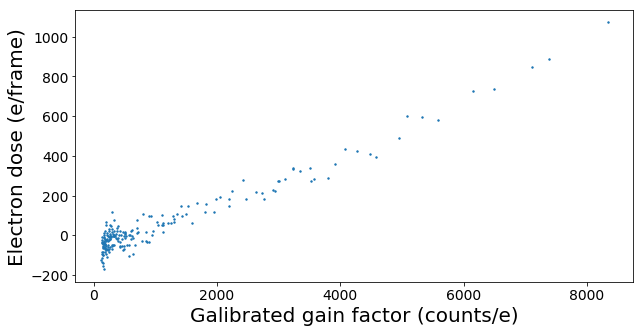

In [85]:
fig = plt.figure(figsize=(10,5))
im = plt.scatter(np.asarray(nevent_list),np.asarray(intensity_list),s=2)
plt.xlabel('Galibrated gain factor (counts/e)',fontsize=20)
plt.ylabel('Electron dose (e/frame)',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [83]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [100]:
path = '/srv/home/chenyu/DEbackup/053019/LowDoseSeries/npy/'
int_list = []
for iframe in range(1,10000,5):
    frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
    frame_binary = np.heaviside(frame-10,1)
    int_list.append(np.sum(frame))

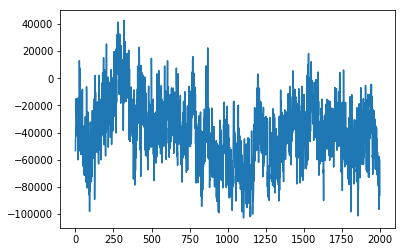

In [101]:
plt.plot(int_list)

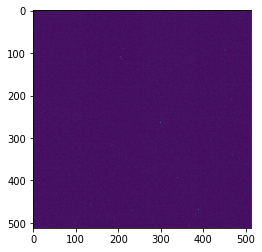

In [95]:
iframe=1500
frame = np.load(path + 'S0_' + format(iframe,'05') + '.npy')
frame_binary = np.heaviside(frame-10,1)
int_list.append(np.sum(frame))
plt.imshow(frame)